In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Telecom Churn Prediction

In this assignment, we worked on the data of telecom customers to predict whether they churned from the service based on a series of variables including user demographics, service list, contract length and cost. We started with data observation and distribution visualization, then set up simple models with resampling technique to carry out the prediction. Details are as follows: 

- [Observe data](#observe)
- [Visualize distributions](#viz)
- [Prediction](#preds)
 - [SMOTE](#smote)
- [Recommendations](#rec)

### Observe data
<a id='observe'></a>

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


From the [appendix](https://eranto.github.io/cs5304-spring2019/assignments/a1/Assignment-1.pdf), among all the variables many are categorical and binary. Among these variables, SeniorCitizen is encoded as 0/1 while others are encoded in yes/no. For the consistency of representation and ease for the prediction, we will encode all of them into one-hot encoding later. We will also do so for variables like PaymentMethod which have more than 2 "levels".

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

There are in total 7043 records, each of which has 20 variables exluding the target "Churn". It is nice that there's no null values for any variables. TotalCharges should be float64.

In [4]:
df['TotalCharges'] = df['TotalCharges'].str.replace(' ', '0').astype(float)
df.describe(include='all')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,...,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043.000000,7043
unique,7043,2,NaN,2,2,NaN,2,3,3,3,...,3,3,3,3,3,2,4,NaN,NaN,2
top,7951-QKZPL,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,NaN,No
freq,1,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,...,3095,3473,2810,2785,3875,4171,2365,NaN,NaN,5174
mean,NaN,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,2279.734304,NaN
std,NaN,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,2266.794470,NaN
min,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,0.000000,NaN
25%,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,398.550000,NaN
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,1394.550000,NaN
75%,NaN,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,3786.600000,NaN


At a glance, the values of numerical variables look legal and even pretty balanced. However, many binary variables such as MutipleLines have 3 levels. We will have a closer look at those.

In [5]:
cols = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in cols:
    print('\n' + col)
    print(df[col].value_counts())


MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64

OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64

OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64

DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: DeviceProtection, dtype: int64

TechSupport
No                     3473
Yes                    2044
No internet service    1526
Name: TechSupport, dtype: int64

StreamingTV
No                     2810
Yes                    2707
No internet service    1526
Name: StreamingTV, dtype: int64

StreamingMovies
No                     2785
Yes                    2732
No internet service    1526
Name: StreamingMovies, dtype: int64


It actually make sense. Look at other categorical variables.

In [6]:
cols = ['Contract', 'PaymentMethod']
for col in cols:
    print('\n' + col)
    print(df[col].value_counts())


Contract
Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64

PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64


In [7]:
df['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

### Visualize distributions
<a id='viz'></a>

In [8]:
df['customerID'] = [i for i in range(1, 7044)]    # changed into integer values, was going to scatterplot
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

0    5174
1    1869
Name: Churn, dtype: int64


Text(0.5,1,'Churn Rate')

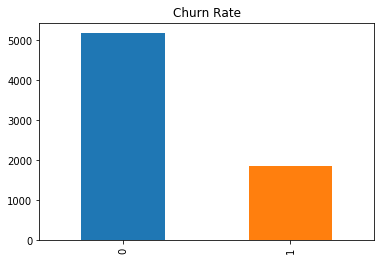

In [9]:
df['Churn'] = df['Churn'].astype('category').cat.codes
cnt = df['Churn'].value_counts()
print(cnt)
cnt.plot.bar()
plt.title('Churn Rate')

Choose some variables that we think would have impact on Churn to see their actuall relationship with Churn.

In [10]:
plt.rcParams['image.cmap'] = 'RdBu'
cat_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod']
num_cols = ['MonthlyCharges', 'TotalCharges']

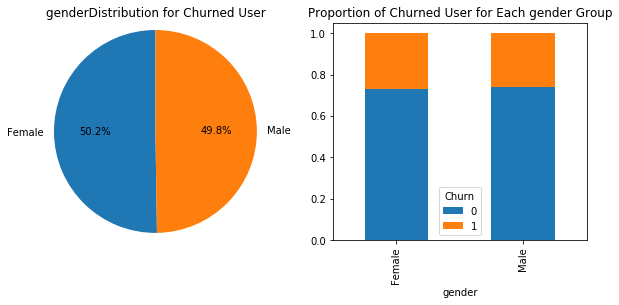

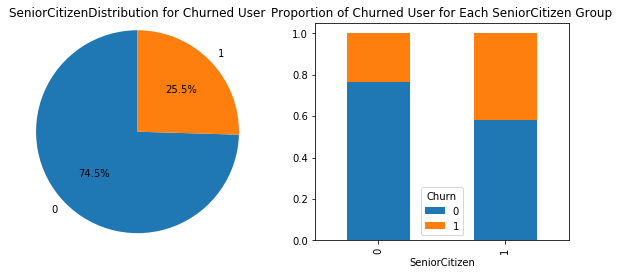

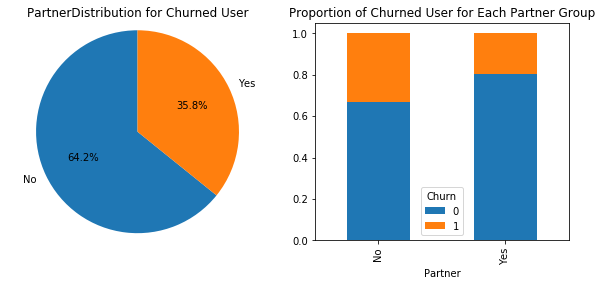

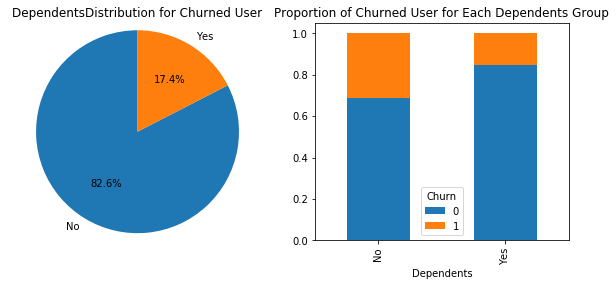

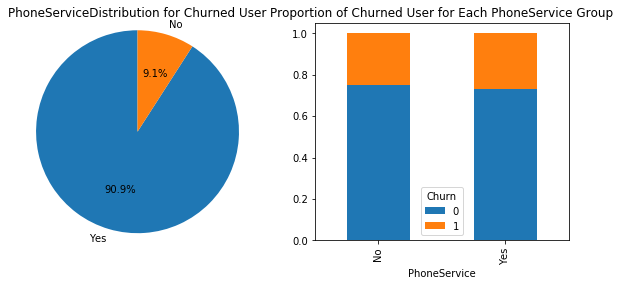

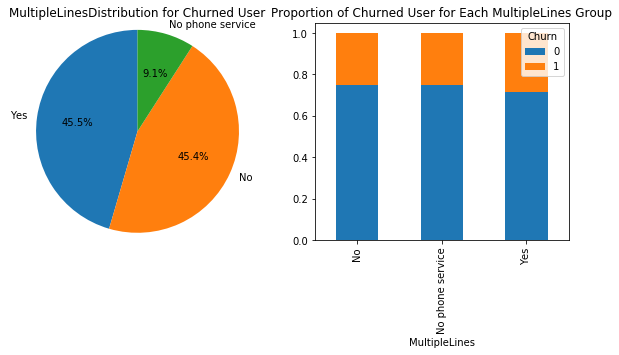

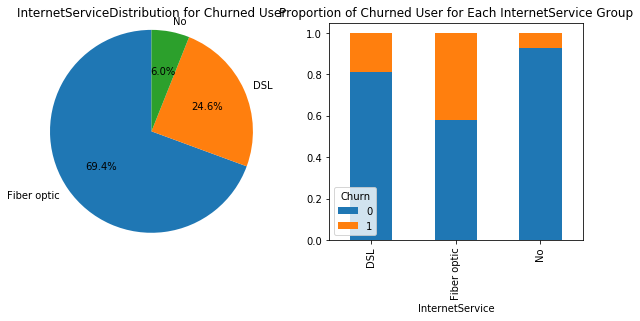

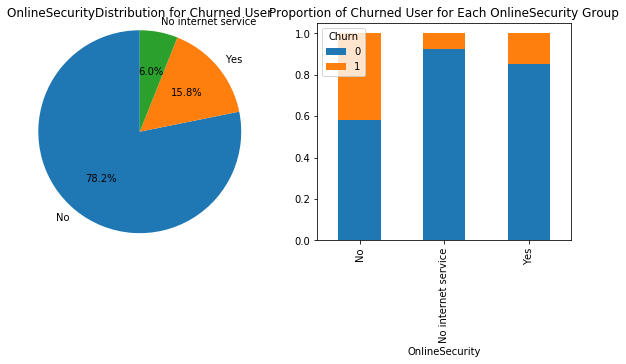

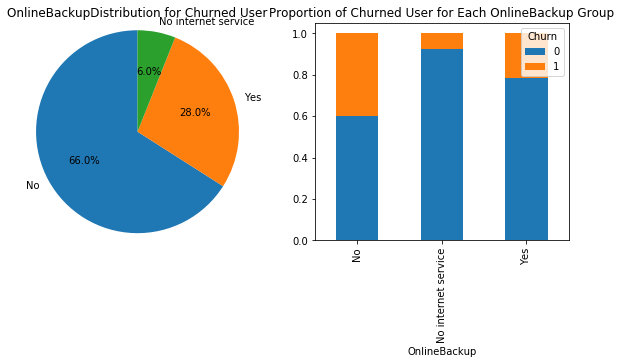

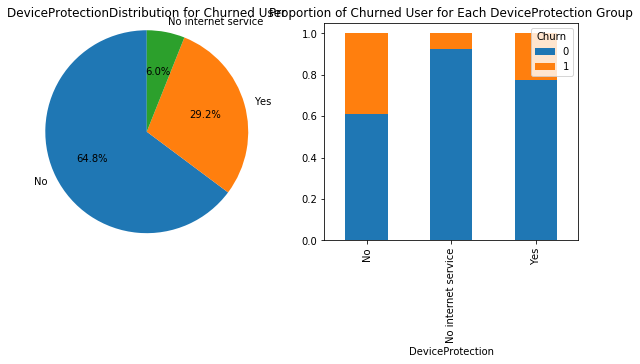

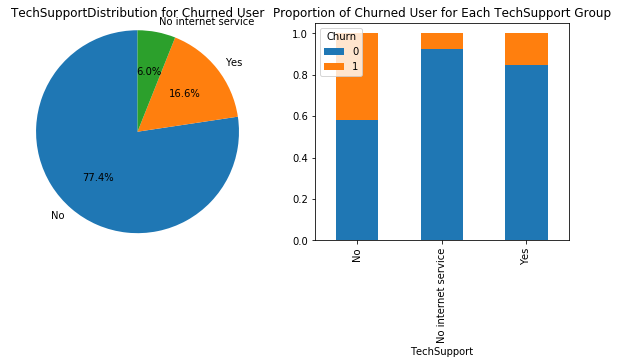

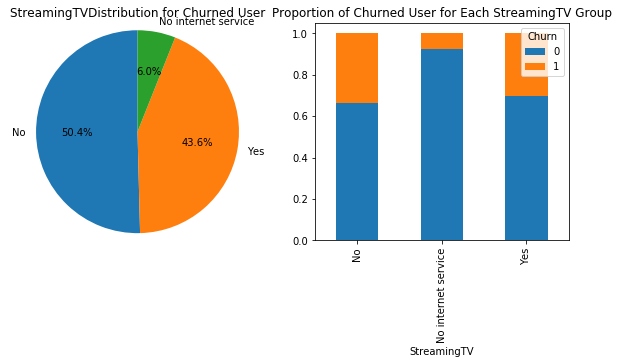

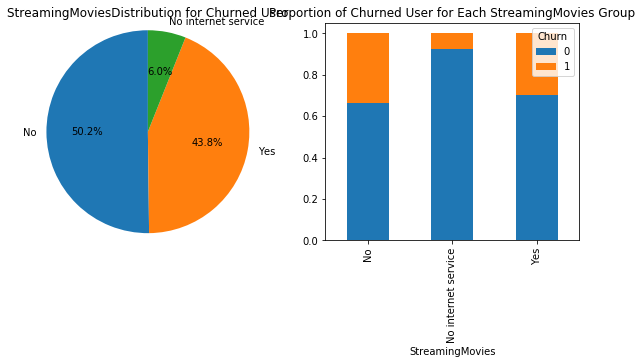

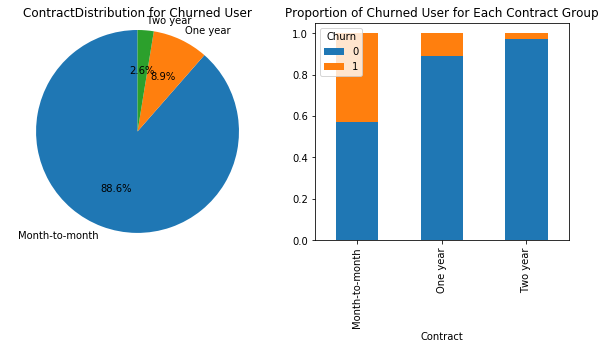

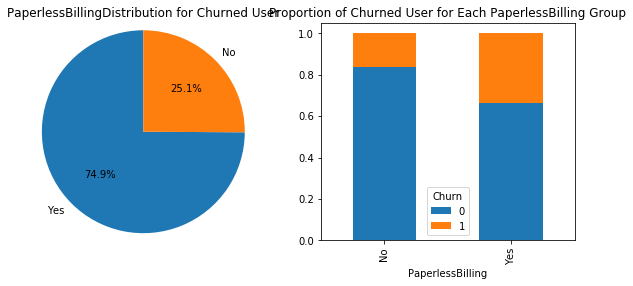

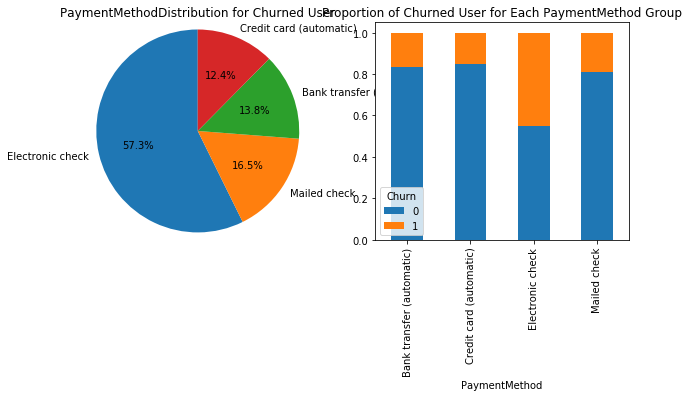

In [11]:
def plot_cat(col):
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,4))
    sizes = df[df['Churn']==1][col].value_counts().values.tolist()
    labels = df[df['Churn']==1][col].value_counts().keys().tolist()
    ax1.axis('equal')
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    ax1.set_title(col + 'Distribution for Churned User')
    
    tmp = df.groupby([col, 'Churn']).size().unstack()
    ax2 = tmp.div(tmp.sum(1).astype(float), axis=0).plot.bar(stacked=True, ax=ax2)
    ax2.set_title('Proportion of Churned User for Each ' + col + ' Group')
    
for col in cat_cols:
    plot_cat(col)
    
# sizes = df[df['Churn']==1]['gender'].value_counts().values.tolist()

From the graphs, we identify that senior citizens, people without partners and people without dependents tend to have higher churn rate. Besides, the types of internet service vary amoung churned and non-churned users. Users with fiber optic tend to have higehr churn rate, followed by DSL then without internet service. Finally, users without any security, backup, tech-support or entertainment plans are more likely to churn compared with those who have.

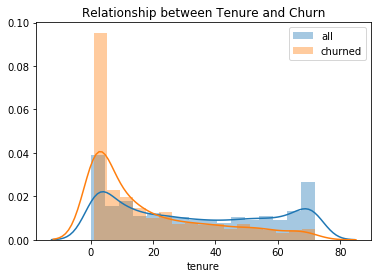

In [12]:
sns.distplot(df['tenure'], label='all')
sns.distplot(df[df['Churn']==1]['tenure'], label='churned')
plt.title('Relationship between Tenure and Churn')
plt.legend()

According to the graph, we figure out that the shorter the tenure, the greater the churn rate. Users who stay with the company for a shorter peroid of time are more likely to leave. The highest churn rate occurs amoung users who stay with the company for fewer than 12 months.

Text(0.5,1,'TotalCharges Distribution according to Churn')

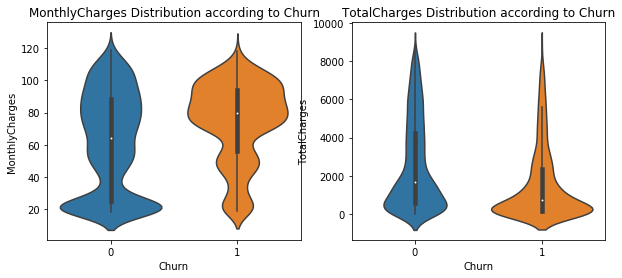

In [14]:
# sns.scatterplot(x='customerID', y='MonthlyCharges', hue='Churn', data=df)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 4))
ax1 = sns.violinplot(x='Churn', y='MonthlyCharges', data=df, ax=ax1)
ax2 = sns.violinplot(x='Churn', y='TotalCharges', data=df, ax=ax2)
ax1.set_title('MonthlyCharges Distribution according to Churn')
ax2.set_title('TotalCharges Distribution according to Churn')

Users with large monthly charges are more likely to leave. However, when it comes to total charge, reducing total charges does not necessarily lead to lower churn rate.
<br> With the genral distribution in mind, we built the prective model aiming to check out the most influential variables on churn.

### Prediction
<a id='preds'></a>

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE

In [16]:
cols = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender', 'Partner', 'Dependents', 'PhoneService', 'InternetService', 'Contract', 'PaperlessBilling', 'PaymentMethod']
df = pd.get_dummies(df, columns=cols)
df.shape

(7043, 47)

For the categorical variables, we one-hot encoded them into dummy variables, because there is no relationship between different levels.

In [17]:
col_list = df.columns.tolist()
df = df[col_list[:5] + col_list[6:] + [col_list[5]]]
df.columns

Index(['customerID', 'SeniorCitizen', 'tenure', 'MonthlyCharges',
       'TotalCharges', 'MultipleLines_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'gender_Female', 'gender_Male', 'Partner_No',
       'Partner_Yes', 'Dependents_No', 'Dependents_Yes', 'PhoneService_No',
       'PhoneService_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'Contract_Month-to-month', 'Contract_One year', 'Contract_Two y

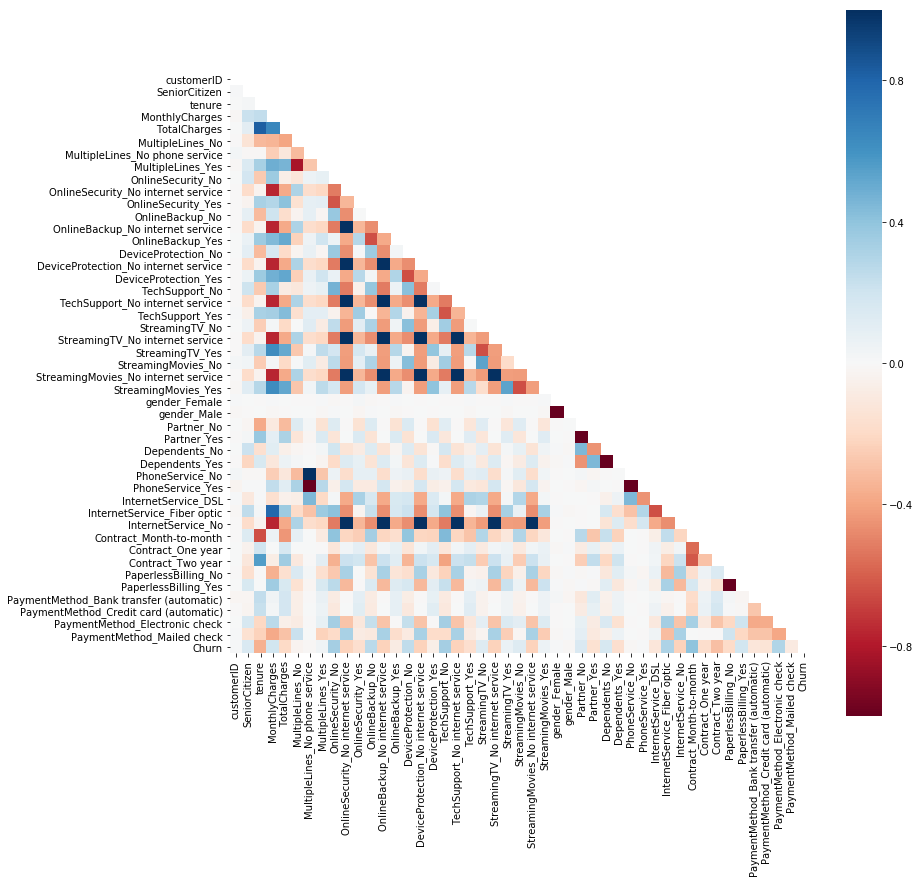

In [18]:
plt.figure(figsize=(13,13))
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, square=True, cmap='RdBu', mask=mask)

For the ease of observing the correlation between target variable and input variables, put Churn at the end. According to the heatmap, short contract, no tech-support, no online security service seem to have the most positive correlation with churn. While, long tenure, long contract and no internet service tend to be negatively related to churn.

In [19]:
# x_train, x_test, y_train, y_test = train_test_split(df.drop(['Churn', 'customerID', 'MonthlyCharges', 'TotalCharges'], axis=1), df['Churn'], test_size=0.2, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(df.drop(['Churn', 'customerID'], axis=1), df['Churn'], test_size=0.2, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(5634, 45) (1409, 45) (5634,) (1409,)


For the model, we splitted the whole data set into training set and test set at a rate of 4:1. Next we trained Logistic Regression and Random Forest Classifier model, then alleviated the class imbalance problem with SMOTE. Within each model, we carried out 5-fold cross validation for the purpose of better generalization. For evaluation, we compared accuracy score, precision/recall/F1 score (from classification report), and AUROC. We finally had a look at the feature importance (normalized coefficients for Logistic Regression) to see the impact of each variable as a rationale for the recommendations.

In [24]:
def predict(model_name, x_train, x_test, y_train, y_test):
    if model_name == 'lr':
        model = LogisticRegression()
    if model_name == 'rf':
        model = RandomForestClassifier()
    print('===========================================================================')
    print(model)
    print('\ncross_val_score:', cross_val_score(model, x_train, y_train, cv=KFold(5)))
    
    model = model.fit(x_train, y_train)
    preds = model.predict(x_test)
    pred_probas = model.predict_proba(x_test)
    print('\naccuracy_score:', accuracy_score(y_test, preds))
    print(classification_report(y_test, preds))
    print('\nroc_auc_score:', roc_auc_score(y_test, preds))
    
    fpr, tpr, _ = roc_curve(y_test, pred_probas[:,1])
    
    if model_name == 'lr':
        fi = pd.Series(model.coef_[0]*np.std(x_train, 0), index=df.drop(['Churn', 'customerID'], axis=1).columns).sort_values()
    if model_name == 'rf':
        fi = pd.Series(model.feature_importances_, index=df.drop(['Churn', 'customerID'], axis=1).columns).sort_values()
    print('\nFeature importances:', fi)
    return fpr, tpr, fi

In [25]:
fpr_lr, tpr_lr, fi_lr = predict('lr', x_train, x_test, y_train, y_test)
fpr_rf, tpr_rf, fi_rf = predict('rf', x_train, x_test, y_train, y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

cross_val_score: [0.80567879 0.81632653 0.7905945  0.78970719 0.80639432]

accuracy_score: 0.8168914123491838
              precision    recall  f1-score   support

           0       0.86      0.89      0.88      1036
           1       0.67      0.60      0.63       373

   micro avg       0.82      0.82      0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.81      0.82      0.81      1409


roc_auc_score: 0.7476619189085677


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework


Feature importances: tenure                                    -1.405873
Contract_Two year                         -0.229814
InternetService_DSL                       -0.171210
OnlineSecurity_Yes                        -0.121107
MultipleLines_No                          -0.119167
PaperlessBilling_No                       -0.112814
TechSupport_Yes                           -0.106047
PhoneService_Yes                          -0.079047
PaymentMethod_Credit card (automatic)     -0.074875
StreamingMovies_No                        -0.070803
Dependents_Yes                            -0.066926
Contract_One year                         -0.061887
OnlineBackup_Yes                          -0.059937
Partner_No                                -0.056945
PaymentMethod_Mailed check                -0.052881
gender_Male                               -0.047750
TechSupport_No internet service           -0.045424
StreamingTV_No internet service           -0.045424
InternetService_No                        

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 


cross_val_score: [0.77728483 0.77373558 0.75865129 0.78793256 0.78507993]

accuracy_score: 0.7714691270404542
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1036
           1       0.59      0.43      0.50       373

   micro avg       0.77      0.77      0.77      1409
   macro avg       0.70      0.66      0.68      1409
weighted avg       0.76      0.77      0.76      1409


roc_auc_score: 0.6627288912811702

Feature importances: StreamingMovies_No internet service        0.000000
StreamingTV_No internet service            0.000420
TechSupport_No internet service            0.000468
OnlineBackup_No internet service           0.000475
InternetService_No                         0.000627
PhoneService_Yes                           0.002756
DeviceProtection_No internet service       0.002787
MultipleLines_No phone service             0.003233
PhoneService_No                            0.003912
OnlineSecurity_No internet service   

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [26]:
def plot_roc(fpr_lr, tpr_lr, fpr_rf, tpr_rf):
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_lr, tpr_lr, label='LR')
    plt.plot(fpr_rf, tpr_rf, label='RF')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

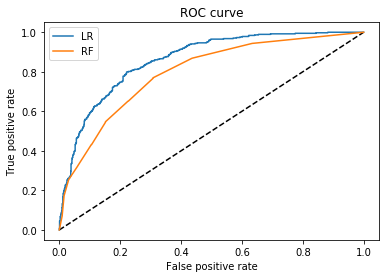

In [27]:
plot_roc(fpr_lr, tpr_lr, fpr_rf, tpr_rf)

There clearly is the class imbalance problem, reflected by the low recall of class labeled '1' from both models. Logistic regression outperformed random forest surprisingly.

In [28]:
def plot_fi(fi_lr, fi_rf):
    fig, [ax1,ax2] = plt.subplots(2, 1, figsize=(8, 16))
    ax1 = fi_lr.plot.barh(ax=ax1, cmap='RdBu')
    ax2 = fi_rf.plot.barh(ax=ax2, cmap='RdBu')
    ax1.set_title('Feature Importances (Normalized Coefficients) of Logistic Regression')
    ax2.set_title('Feature Importances of Random Forest')

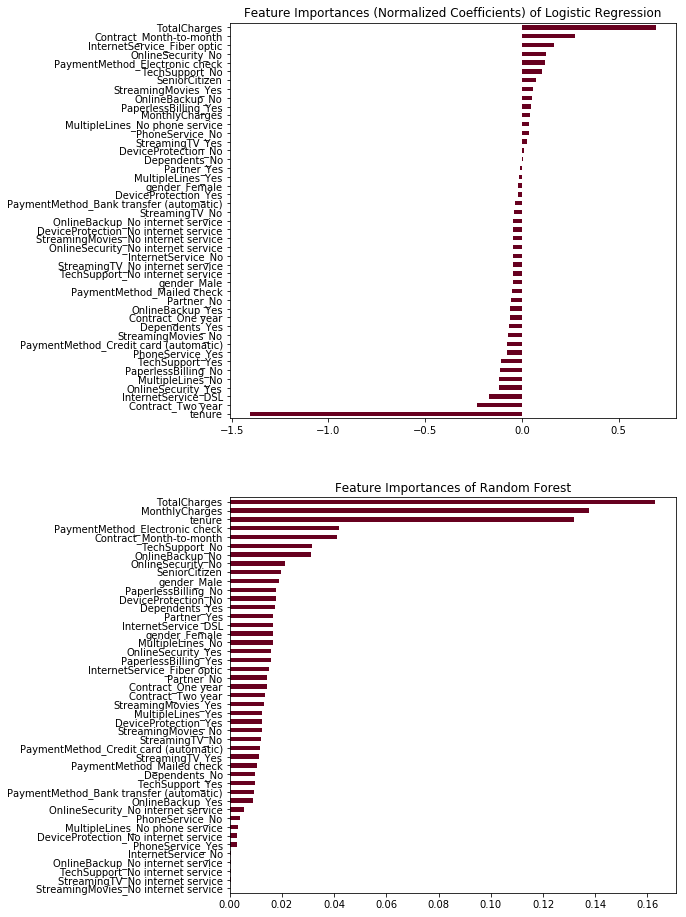

In [29]:
plot_fi(fi_lr, fi_rf)

#### SMOTE
<a id='smote'></a>

In [30]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['Churn', 'customerID'], axis=1), df['Churn'], test_size=0.2, random_state=42)

print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(x_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 1496
Before OverSampling, counts of label '0': 4138 

After OverSampling, the shape of train_X: (8276, 45)
After OverSampling, the shape of train_y: (8276,) 

After OverSampling, counts of label '1': 4138
After OverSampling, counts of label '0': 4138


In [31]:
fpr_lr_os, tpr_lr_os, fi_lr_os = predict('lr', x_train_res, x_test, y_train_res, y_test)
fpr_rf_os, tpr_rf_os, fi_rf_os = predict('rf', x_train_res, x_test, y_train_res, y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework


cross_val_score: [0.72222222 0.72749245 0.71601208 0.77522659 0.70090634]

accuracy_score: 0.7579843860894251
              precision    recall  f1-score   support

           0       0.92      0.74      0.82      1036
           1       0.53      0.82      0.64       373

   micro avg       0.76      0.76      0.76      1409
   macro avg       0.72      0.78      0.73      1409
weighted avg       0.82      0.76      0.77      1409


roc_auc_score: 0.7779482853209395

Feature importances: tenure                                    -1.475933
Contract_Two year                         -0.279842
InternetService_DSL                       -0.140287
OnlineSecurity_Yes                        -0.117573
MultipleLines_No                          -0.097306
PaperlessBilling_No                       -0.095735
TechSupport_Yes                           -0.092795
PaymentMethod_Credit card (automatic)     -0.071575
PhoneService_Yes                          -0.065005
OnlineBackup_Yes                     

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version


cross_val_score: [0.7807971  0.77160121 0.78610272 0.9021148  0.97280967]

accuracy_score: 0.7877927608232789
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1036
           1       0.63      0.49      0.55       373

   micro avg       0.79      0.79      0.79      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.78      0.79      0.78      1409


roc_auc_score: 0.6909864192035775

Feature importances: TechSupport_No internet service            0.000195
StreamingMovies_No internet service        0.000334
StreamingTV_No internet service            0.000571
OnlineSecurity_No internet service         0.000680
InternetService_No                         0.001469
PhoneService_Yes                           0.002583
MultipleLines_No phone service             0.002835
PhoneService_No                            0.003033
DeviceProtection_No internet service       0.003643
DeviceProtection_Yes                 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


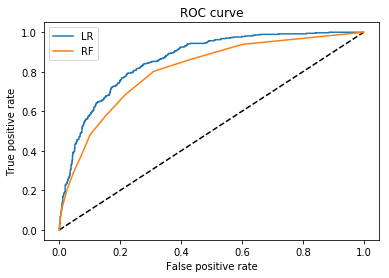

In [32]:
plot_roc(fpr_lr_os, tpr_lr_os, fpr_rf_os, tpr_rf_os)

Witht SMOTE, the churned class was oversampled to the same count as the non-churned class. For performance, we observed a reasonable drop in overall accuracy (because for imbalanced data set, the model can achieve a high accuracy by predict all records as churned, but it's of no use for us), and a slight increase in AUROC, which means there is a higher recall for the churned class and the models improved with the distinguishability.

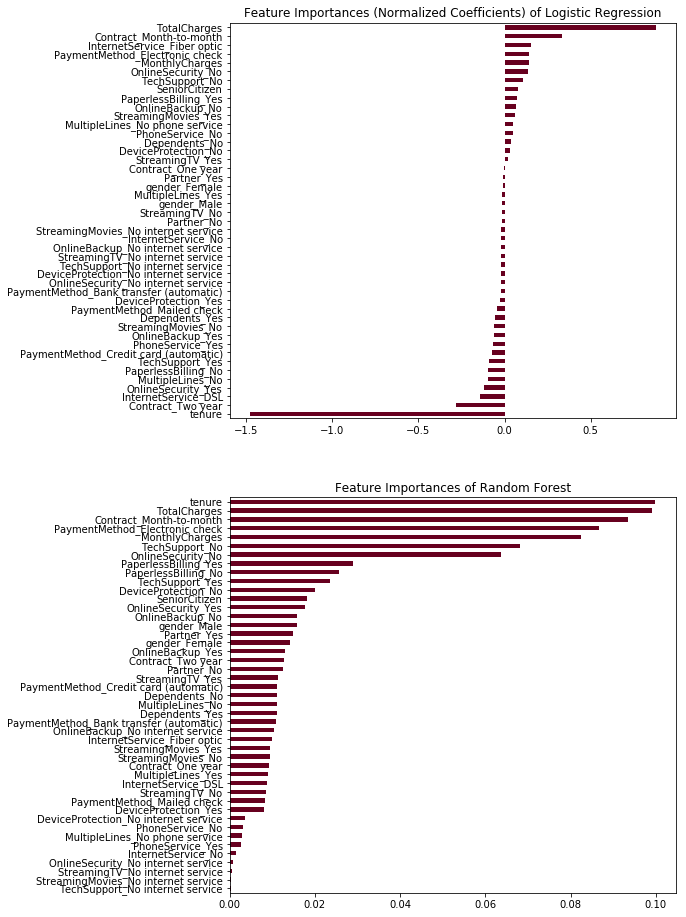

In [33]:
plot_fi(fi_lr_os, fi_rf_os)

From logistic regression, we identified that total charges, short-term contract, fiber optic etc. add the likelihood of users to churn while long-term contract and including internet service like DSL and online security do the opposite. Random forest came to very similar conclusion that charges, tenure, contract legth and some add-on service occupy more importance than other features.

### Recommendations
<a id='rec'></a>

- The shorter the tenure/contract, the more likely a user would like to churn. It reflects a large number of customers churned at early days using our service, and we have to work better to retain users. We can promote those packages with longer period, eg. one-year, two-year to keep customers around.
- For SMOTE, a new variable 'PaymentMethod_ElectronicCheck' topped the feature importance. Further, automatic payments do better in retaining a user. We can encourage customers to use automatic payment methods eg. credit card, bank transfer by giving them some discount or payback options.
- Customer with FiOS internet service are likely to churn while it's the opposite for DSL customers, although the speed of FiOS is way faster than DSL. It might be the price of FiOS are too high and cannot outweight the speed, and customers are satisfied enough with basic internet on mobiles. We could adjust proportion of the investment in FiOS/DSL to keep the option for high end users, while investing more on the basic option.
- Generally, the more services a customer uses (eg. online security, tech support), the less likely he is going to churn. We could include these services as a default within the packages (and raise the charge accordingly).
- Seniors churn a lot. No matter what's the reason, we could design some senior-friendly offerings to attract them. For example, we can cut things that a typical senior wouldn't regularly use such as streaming service or paperless billing, and add things like reading out the caller ID for the convenience of taking a call.